In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from flow_viz import visualize_optical_flow
from typing import Iterable, List
from utils import load_sequence
import os

In [2]:
source_image: np.ndarray = cv2.imread('data/I.jpg', cv2.IMREAD_GRAYSCALE)
target_image: np.ndarray = cv2.imread('data/J.jpg', cv2.IMREAD_GRAYSCALE)

PEDESTRIAN_PATH: str = r"C:\Users\igor\Desktop\Studia\I\Semestr6\ZAW\Lab2\pedestrian"
HIGHWAY_PATH: str = r"C:\Users\igor\Desktop\Studia\I\Semestr6\ZAW\Lab2\highway\highway"

In [3]:
pedestrian_sequence: List[np.ndarray] = load_sequence(PEDESTRIAN_PATH)

highway_sequence: List[np.ndarray] = load_sequence(HIGHWAY_PATH)

In [4]:
lk_params = dict( winSize  = (15, 15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 10, 0.03))

feature_params = dict( 
    maxCorners = 100,
    qualityLevel = 0.3,
    minDistance = 7,
    blockSize = 7 
)

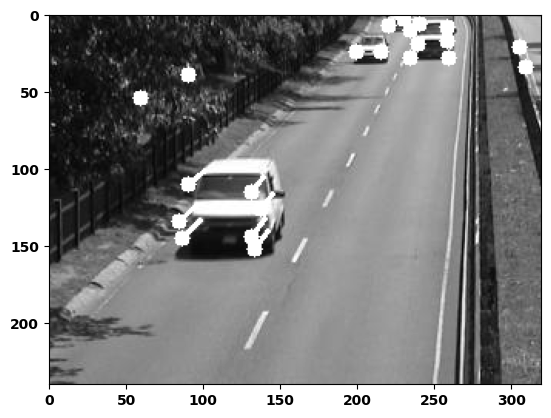

In [5]:
# Lucas-Kanade optical flow

# find the keypoints with Shi-Tomasi
p0: np.ndarray = cv2.goodFeaturesToTrack(source_image, mask = None, **feature_params)

# calculate optical flow
p1, st, err = cv2.calcOpticalFlowPyrLK(source_image, target_image, p0, None, **lk_params)

# Select good points
good_new = p1[st==1]
good_old = p0[st==1]

mask = np.zeros_like(source_image)

for i, (new, old) in enumerate(zip(good_new, good_old)):
    a, b = new.ravel()
    c, d = old.ravel()
    mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), [255], 2)
    source_image = cv2.circle(source_image, (int(a), int(b)), 5, [255], -1)

plt.imshow(cv2.add(source_image, mask), cmap='gray')
plt.show()

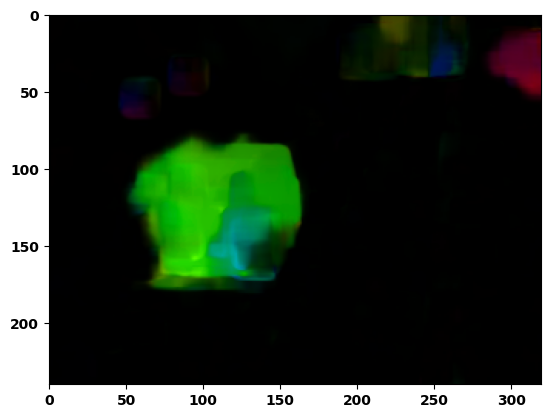

In [6]:
flow = cv2.calcOpticalFlowFarneback(source_image, target_image, None, 0.5, 3, 15, 3, 5, 1.2, 0)

visualize_optical_flow(flow[:,:,0], flow[:,:,1])

2.

In [7]:

def optical_flow_based_object_classification(
        images_stream: List[np.ndarray],
        init_mask: np.ndarray,
        history: int = 100,
        alpha: float = 0.01,
        detect_shadows: bool = False,
        threshold: float = 16
    ) -> Iterable[np.ndarray]:
    background_model = cv2.createBackgroundSubtractorMOG2(history=history, varThreshold=threshold, detectShadows=detect_shadows)
    mask: np.ndarray = init_mask.copy()
    previous_image: np.ndarray = init_mask.copy()
    for image in images_stream:
        mask: np.ndarray = background_model.apply(image, learningRate=alpha)
        temp = image.copy()
        flow = cv2.calcOpticalFlowFarneback(previous_image, image, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        mag, ang = cv2.cartToPolar(flow[:,:,0].astype(np.float64), flow[:,:,1].astype(np.float64))

        previous_image = image
        count, indxed, stats, centroids  = cv2.connectedComponentsWithStats(mask)

        for i in range(1, count):
            roi_mag: np.ndarray = (indxed==i).astype(np.float64)*mag
            roi_ang: np.ndarray = (indxed==i).astype(np.float64)*ang/(np.pi*2)
            if (indxed==i).astype(np.float64).sum() < 5 or roi_mag.mean() < 0.01:
                continue
            cv2.rectangle(temp, (stats[i, 0],stats[i, 1]), (stats[i, 0]+stats[i, 2], stats[i, 1]+stats[i, 3]), (0,0,0), 2)
            text: str = f"std:{format(roi_mag.std(),'.4f')}, {format(roi_ang.std(), '.4f')}"
            cv2.putText(temp, text,(np.int(centroids[i,0]), np.int(centroids[i,1])), cv2.FONT_HERSHEY_SIMPLEX, .5, (0))

        yield temp

In [10]:
def display_optical_flow_based_recognition(
        sequence: List[np.ndarray], 
        init_mask: np.ndarray
    ) -> None:
    for image in optical_flow_based_object_classification(
            images_stream=sequence,
            init_mask=init_mask,
        ):
        cv2.imshow("I",image)
        cv2.waitKey(10)
        if cv2.waitKey(1) & 0xFF == ord("q"): break
    cv2.destroyAllWindows()

In [9]:
display_optical_flow_based_recognition(pedestrian_sequence, pedestrian_sequence[0])

C:\Users\igor\AppData\Local\Temp\ipykernel_36836\2378131481.py:28: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cv2.putText(temp, text,(np.int(centroids[i,0]), np.int(centroids[i,1])), cv2.FONT_HERSHEY_SIMPLEX, .5, (0))


KeyboardInterrupt: 

In [11]:
display_optical_flow_based_recognition(highway_sequence, highway_sequence[0])

C:\Users\igor\AppData\Local\Temp\ipykernel_36836\2378131481.py:28: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cv2.putText(temp, text,(np.int(centroids[i,0]), np.int(centroids[i,1])), cv2.FONT_HERSHEY_SIMPLEX, .5, (0))
